In [22]:
import os
import datetime
from typing import List, Tuple

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import signal



def read_usgs_data(file_path: str) -> pd.DataFrame:
    """
    Read USGS data from a file and return a DataFrame.
    
    Args:
    file_path (str): Path to the USGS data file.
    
    Returns:
    pd.DataFrame: DataFrame containing USGS data.
    """
    with open(file_path, 'r') as file:
        all_lines = file.readlines()

    dates = []
    heights = []
    for line in all_lines[26:]:
        ll = line.split('\t')
        if ll[-1] == 'A\n':
            dates.append(datetime.datetime.strptime(ll[2], '%Y-%m-%d %H:%M'))
            heights.append(float(ll[4]))

    data_dict = {'DATE': dates, 'gauge_heights': heights}
    return pd.DataFrame(data_dict)


def find_missing_dates(df: pd.DataFrame, date_col: str = 'DATE', 
                       threshold: datetime.timedelta = datetime.timedelta(minutes=15)) -> Tuple[datetime.timedelta, datetime.timedelta]:
    """
    Find gaps in the date column of a DataFrame.
    
    Args:
    df (pd.DataFrame): Input DataFrame.
    date_col (str): Name of the date column.
    threshold (datetime.timedelta): Threshold for considering a gap.
    
    Returns:
    Tuple[datetime.timedelta, datetime.timedelta]: Maximum gap and total gap.
    """
    prev = df[date_col].iloc[0]
    total_gap = datetime.timedelta(minutes=0)
    max_diff = threshold

    for d in df[date_col].iloc[1:]:
        diff = d - prev
        if diff > max_diff:
            max_diff = diff
        if diff > threshold:
            total_gap += diff
            print(f"Gap found between {prev} and {d}")
        prev = d

    print(f'Max gap: {max_diff}')
    print(f'Total gap: {total_gap}')
    return max_diff, total_gap


def detect_sudden_jumps(df: pd.DataFrame, column: str, threshold: float) -> pd.Series:
    """
    Detect sudden jumps between consecutive data points in a time series.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column name containing the data to check for jumps.
    threshold (float): The maximum allowable difference between consecutive points.
    
    Returns:
    pd.Series: A boolean series indicating potential errors (True = error).
    """
    diffs = df[column].diff().abs()
    return diffs > threshold


def process_usgs_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process USGS data: set index, fill missing values, and interpolate.
    
    Args:
    df (pd.DataFrame): Input DataFrame with USGS data.
    
    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    df.set_index('DATE', inplace=True)
    df.sort_index(inplace=True)
    df = df.groupby(df.index).mean()

    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='15min')
    df_filled = df.reindex(full_range)
    df_filled['gauge_heights'] = df_filled['gauge_heights'].interpolate(method='time')

    df_filled.reset_index(inplace=True)
    df_filled.rename(columns={'index': 'DATE'}, inplace=True)
    return df_filled


def fill_missing_dates(df: pd.DataFrame, freq = '15min' ) -> pd.DataFrame:
    """
    Process USGS data: set index, fill missing values, and interpolate.
    
    Args:
    df (pd.DataFrame): Input DataFrame with USGS data.
    
    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    df.set_index('DATE', inplace=True)
    df.sort_index(inplace=True)
    df = df.groupby(df.index).mean()

    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
    df_filled = df.reindex(full_range)
    
    df_filled.reset_index(inplace=True)
    df_filled.rename(columns={'index': 'DATE'}, inplace=True)
    return df_filled


def read_airport_data(file_path: str, start_date: str = '2008-01-01 00:00') -> pd.DataFrame:
    """
    Read and process airport data from a CSV file with improved error handling and reporting.
    
    Args:
    file_path (str): Path to the airport data CSV file.
    start_date (str): Start date for filtering data.
    
    Returns:
    pd.DataFrame: Processed airport data.
    """
    relevant_cols = {
        'DATE': 'DATE',
        'HourlyWetBulbTemperature': 'WetBulbTemp',
        'HourlyDryBulbTemperature': 'DryBulbTemp',
        'HourlyPrecipitation': 'Precip',
        'HourlyRelativeHumidity': 'RelHumidity',
        'HourlyWindSpeed': 'WindSpeed',
        'HourlyStationPressure': 'Stationpressure'
    }

    data = pd.read_csv(file_path, usecols=relevant_cols.keys(), 
                       na_values=['None', ''], 
                       low_memory=False)
    
    print(f"Initial data shape: {data.shape}")
    print(f"Initial NaN counts:\n{data.isna().sum()}")

    # Process precipitation data
    data['HourlyPrecipitation'] = data['HourlyPrecipitation'].replace('T', 0.005)

    # Convert columns to numeric, preserving non-numeric values for debugging
    for col in data.columns:
        if col != 'DATE':
            # convert non numeric invalid values to NaN
            non_numeric_mask = pd.to_numeric(data[col], errors='coerce').isna() & data[col].notna()
            non_numeric_values = data.loc[non_numeric_mask, col].unique()
            if len(non_numeric_values) > 0:
                print(f"Non-numeric values in {col}:\n{non_numeric_values}")
            data[col] = pd.to_numeric(data[col], errors='coerce')

    print(f"NaN counts after numeric conversion:\n{data.isna().sum()}")

    # Convert 'DATE' to pandas' datetime objects
    data['DATE'] = pd.to_datetime(data['DATE'], errors='coerce')
    invalid_dates = data[data['DATE'].isna()]
    if not invalid_dates.empty:
        print(f"Invalid dates:\n{invalid_dates['DATE'].unique()}")

    # Set DATE as index
    data.set_index('DATE', inplace=True)
    original_shape = data.shape
    data.index = data.index.round('h')

    data = data[data.index.minute == 0]
    data.rename(columns=relevant_cols, inplace=True)
    data = data[~data.index.duplicated(keep='first')]

    data = data[data.index >= start_date]

    print(f"Final data shape: {data.shape}")
    print(f"Final NaN counts:\n{data.isna().sum()}")

    # remove indexing
    data.reset_index(inplace=True)
    
    return data



def fill_missing_values(data: pd.DataFrame, method='linear') -> pd.DataFrame:
    """
    Process data: interpolate missing values with linear interpolation.
    
    Args:
    data (pd.DataFrame): Input DataFrame with data and 'DATE' column, which will be used as index.
    
    Returns:
    pd.DataFrame: Processed DataFrame.
    """
    data.set_index('DATE', inplace=True)
    data.sort_index(inplace=True)
    data = data.groupby(data.index).mean()
    
    for col in data.columns:
        data[col] = data[col].interpolate(method='time')

    data.reset_index(inplace=True)
    data.rename(columns={'index': 'DATE'}, inplace=True)
    return data


def resample_to_hourly(df: pd.DataFrame) -> pd.DataFrame:
    """
    Resample 15-minute data to hourly data without filling missing values.
    It resamples by calculating mean for each column, this method will not work for 
    something like precipitaion where we need to do sum instead.
    
    Args:
    df (pd.DataFrame): Input DataFrame with 15-minute data.
    value_column (str): Name of the column containing the values to be resampled.
    
    Returns:
    pd.DataFrame: Resampled DataFrame with hourly data.
    """
    
    df.set_index('DATE', inplace=True)
    df = df.sort_index()
    
    # Resample to hourly frequency, using the mean
    resampled = df.resample('H', label='left', closed='left').mean()
    
    # Reset the index to make the DATE a column again
    resampled.reset_index(inplace=True)
    resampled.rename(columns={'index': 'DATE'}, inplace=True)

    return resampled

In [23]:
def combine_dataframes(df1, df2, common_col = 'DATE'):
    df1.set_index(common_col, inplace=True)
    df2.set_index(common_col, inplace=True)

    min_date = max(df1.index.min(), df2.index.min())
    max_date = min(df1.index.max(), df2.index.max())

    df = pd.concat([df1, df2], axis = 1)
    df = df[min_date:max_date]
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'DATE'}, inplace=True)

    return df

In [24]:
usgs_df = read_usgs_data('../dataset/usgs_data.html')
river_df = fill_missing_dates(usgs_df, '15min')
print(river_df.describe())

river_df = resample_to_hourly(river_df)
# we need to observe the data statistics if it changes significantly 
# when we resample data, since there is information loss
print(river_df.describe())

rain_df = read_airport_data('../dataset/raw_data/Fulton_county_full.csv')
rain_df = fill_missing_dates(rain_df, '1h')

                                DATE  gauge_heights
count                         575363  571121.000000
mean   2016-03-15 16:15:00.000000512       6.574456
min              2008-01-01 00:00:00       2.790000
25%              2012-02-07 08:07:30       4.300000
50%              2016-03-15 16:15:00       5.480000
75%              2020-04-22 00:22:30       7.920000
max              2024-05-29 08:30:00      27.860000
std                              NaN       2.980629
                      DATE  gauge_heights
count               143841  142950.000000
mean   2016-03-15 16:00:00       6.573264
min    2008-01-01 00:00:00       2.795000
25%    2012-02-07 08:00:00       4.305000
50%    2016-03-15 16:00:00       5.482500
75%    2020-04-22 00:00:00       7.917500
max    2024-05-29 08:00:00      27.850000
std                    NaN       2.978962


/var/folders/j3/9_pszf256zvgnry9z0x72k_h0000gn/T/ipykernel_16756/3005075981.py:241: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = df.resample('H', label='left', closed='left').mean()


Initial data shape: (210858, 7)
Initial NaN counts:
DATE                            0
HourlyDryBulbTemperature     7399
HourlyPrecipitation         36385
HourlyRelativeHumidity       7777
HourlyStationPressure        7610
HourlyWetBulbTemperature     8426
HourlyWindSpeed              7778
dtype: int64
Non-numeric values in HourlyDryBulbTemperature:
['*']
Non-numeric values in HourlyRelativeHumidity:
['*']
Non-numeric values in HourlyWetBulbTemperature:
['*']
Non-numeric values in HourlyWindSpeed:
['*']
NaN counts after numeric conversion:
DATE                            0
HourlyDryBulbTemperature     8100
HourlyPrecipitation         36385
HourlyRelativeHumidity       8478
HourlyStationPressure        7610
HourlyWetBulbTemperature     9127
HourlyWindSpeed              7779
dtype: int64
Final data shape: (143792, 6)
Final NaN counts:
DryBulbTemp          434
Precip             10636
RelHumidity          628
Stationpressure      464
WetBulbTemp         1077
WindSpeed            700
dtype:

In [ ]:
combined_df = combine_dataframes(river_df, rain_df, 'DATE')

In [ ]:
combined_df

 ### Filling gaps in the data
 Filling gaps in timeseries data itlself is an active area of research. Current best approaches use deep learning models. There are many other different ways to fill missing gaps in data such as
1. Interplolation, linear, spline, etc
2. You can use arima or sarima model as well but they only look at the previous values and not the future values
3. You can use Kalman Filtering to fill the gaps which also considers, previous vlaues, future values along with uncertainty
   
 We are going to use Linear interpolation for simplicity. 
 In theory no one method is better than another, in practial scenario you would normally fill the gap and see if any method improves the result from another. In large dataset with smaller gaps it wouldn't matter much.

In [ ]:
combined_df = fill_missing_values(combined_df)

In [7]:
usgs_df = read_usgs_data('../dataset/usgs_data.html')
river_df = fill_missing_dates(usgs_df, '15min')
river_df = resample_to_hourly(river_df)

rain_df = read_airport_data('../dataset/raw_data/Fulton_county_full.csv')
rain_df = fill_missing_dates(rain_df, '1h')



/var/folders/j3/9_pszf256zvgnry9z0x72k_h0000gn/T/ipykernel_16756/948749151.py:239: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = df.resample('H', label='left', closed='left').mean()


Initial data shape: (210858, 7)
Initial NaN counts:
DATE                            0
HourlyDryBulbTemperature     7399
HourlyPrecipitation         36385
HourlyRelativeHumidity       7777
HourlyStationPressure        7610
HourlyWetBulbTemperature     8426
HourlyWindSpeed              7778
dtype: int64
Non-numeric values in HourlyDryBulbTemperature:
['*']
Non-numeric values in HourlyRelativeHumidity:
['*']
Non-numeric values in HourlyWetBulbTemperature:
['*']
Non-numeric values in HourlyWindSpeed:
['*']
NaN counts after numeric conversion:
DATE                            0
HourlyDryBulbTemperature     8100
HourlyPrecipitation         36385
HourlyRelativeHumidity       8478
HourlyStationPressure        7610
HourlyWetBulbTemperature     9127
HourlyWindSpeed              7779
dtype: int64
Final data shape: (143792, 6)
Final NaN counts:
DryBulbTemp          434
Precip             10636
RelHumidity          628
Stationpressure      464
WetBulbTemp         1077
WindSpeed            700
dtype:

In [8]:
# Let's look at the data for any outliers.

combined_df.describe() 

,DATE,gauge_heights,DryBulbTemp,Precip,RelHumidity,Stationpressure,WetBulbTemp,WindSpeed
count,143812,143812.000000,143812.000000,143812.000000,143812.000000,143812.000000,143812.000000,143812.000000
mean,2016-03-15 01:30:00,6.573415,62.420156,0.005247,69.714551,29.173226,56.222662,4.712566
min,2008-01-01 00:00:00,2.795000,6.000000,0.000000,10.000000,28.260000,4.000000,0.000000
25%,2012-02-07 00:45:00,4.305000,50.000000,0.000000,53.000000,29.080000,45.000000,0.000000
50%,2016-03-15 01:30:00,5.477500,64.000000,0.000000,73.000000,29.170000,59.000000,5.000000
75%,2020-04-21 02:15:00,7.917500,75.000000,0.000000,88.000000,29.270000,69.000000,8.000000
max,2024-05-28 03:00:00,27.850000,103.000000,1.810000,100.000000,29.840000,81.000000,37.000000
std,NaN,2.977784,16.256533,0.034490,20.964192,0.154982,14.439388,4.412699


In [9]:
# Visualize the data


def plot_data(df, start_date, end_date, date='DATE', ceil = 'Precip', floor='gauge_heights'):
    df = df[ (df[date] > start_date) & (df[date] < end_date)]
    df.set_index(date, inplace=True)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color = 'tab:red'
    ax1.set_xlabel(date)
    ax1.set_ylabel(floor, color=color)
    ax1.plot(df.index, df[floor], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 30.0)

    # Create a second y-axis for 'HourlyPrecipitation', same as the first one but inverted
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(ceil, color=color)
    ax2.plot(df.index, df[ceil], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 10.0)
    ax2.invert_yaxis()
    
    plt.title('Gaze Height and Hourly Precipitation Over Time')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
# Window sum

def window_sum(df, n, col):
    latent = list(np.zeros(n-1)) + list(df[col])
    new_list = []
    for i in range(n, len(latent)+1):
        new_list.append(sum(latent[i-n:i]))
    return new_list



In [11]:
combined_df['Precip_Sum_last_13'] = window_sum(combined_df, 13, 'Precip') 



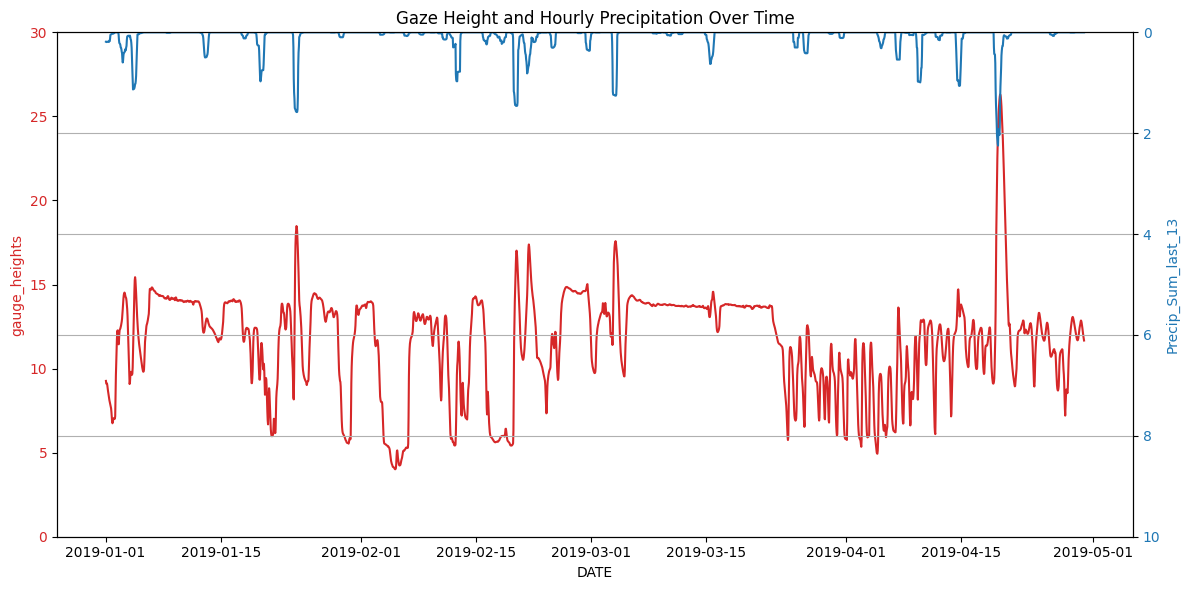

In [12]:
plot_data(combined_df, '2019-01-01', '2019-04-30', 'DATE', 'Precip_Sum_last_13', 'gauge_heights') 

In [13]:
import numpy as np

def cross_corr(x, y):
    """
    Calculate the cross-correlation between two lists, arrays, or pandas Series.
    
    Args:
    x (list, np.array, pd.Series): First input sequence.
    y (list, np.array, pd.Series): Second input sequence.
    lag (int): Time lag (in number of positions) to shift the second sequence. Default is 0 (no lag).
    
    Returns:
    float: The cross-correlation value.
    """
    # Convert inputs to numpy arrays for easier manipulation
    x = np.array(x)
    y = np.array(y)
    
    valid_indices = ~np.isnan(x) & ~np.isnan(y)
    x_clean = x[valid_indices]
    y_clean = y[valid_indices]
    
    # Calculate and return Pearson correlation coefficient
    return np.corrcoef(x_clean, y_clean)[0, 1]

max_cor = 0
max_t = 0
for t in range(1,100):
    wvals = window_sum(combined_df, t, 'Precip')
    cor = cross_corr(wvals, combined_df['gauge_heights'])
    print(cor)
    if cor > max_cor:
        max_cor = cor
        max_t = t


0.08030076082264569
0.10624831668324305
0.1335513853003493
0.16191179032642783
0.190110879373957
0.21714425731998988
0.2424560354856906
0.26574503447976106
0.2868371020763858
0.3057565317822225
0.32261818003737774
0.33762820788757747
0.3510184636757835
0.36294783237653805
0.373583770338069
0.3830609851286228
0.39148786345642983
0.39895435009124297
0.4055230047110295
0.41126521194194654
0.4162930374336312
0.4206890369682624
0.424484204483259
0.42772711713965034
0.43044276551409194
0.43266758812485945
0.4344883218353676
0.4359694895019142
0.4371787432378362
0.4381675512256614
0.43893126163131
0.4394734661543211
0.4398083392535784
0.4399454048628852
0.4398979865494359
0.4396950893783829
0.4393934824845384
0.439040630529754
0.43866333647844113
0.4382619467229883
0.4378167925606204
0.43731649629651936
0.43675073351875654
0.4360919139714204
0.4353459857286065
0.4345189604742315
0.43361177025082465
0.432625841643414
0.4315760544859548
0.4304815446568138
0.42935556478305154
0.42820938336701697

In [14]:
max_t

34

In [15]:
max_cor

np.float64(0.4399454048628852)

In [16]:
# So I find that the correlation is maximum at t = 34 hours, that is precpitation values of past 34 hours is summed.
# What does it mean?

In [17]:
combined_df.set_index('DATE', inplace=True)

combined_df.to_csv('../dataset/final_data.csv', columns=['gauge_heights', 'DryBulbTemp', 'Precip', 'RelHumidity',
       'Stationpressure', 'WetBulbTemp', 'WindSpeed'])
combined_df.reset_index(inplace=True)